# Advanced: LC estimators

## Setup

Let's first make sure we have the latest version of PHOEBE 2.4 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.4,<2.5"

In [2]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger()

## Generate data

Let's first initialize a bundle and change some of the parameter values. We'll then export the computed models as "observables" to use with the [EBAI](../api/phoebe.parameters.solver.estimator.ebai.md) and [lc_geometry](../api/phoebe.parameters.solver.estimator.lc_geometry.md) estimators.

We'll use blackbody atmospheres with manual limb-darkening just to avoid any out-of-bounds errors if the estimates aren't perfectly physical.  Normally we would check these values to make sure they're reasonable before adopting and would definitely want to revert to physical atmospheres and appropriate limb-darkening when optimizing.

In [4]:
b = phoebe.default_binary()
# set parameter values
b.set_value('q', value = 0.6)
b.set_value('incl', component='binary', value = 84.5)
b.set_value('ecc', 0.2)
b.set_value('per0', 63.7)
b.set_value('requiv', component='primary', value=1.)
b.set_value('requiv', component='secondary', value=0.6)
b.set_value('teff', component='secondary', value=5500.)

# add an lc dataset
b.add_dataset('lc', compute_phases=phoebe.linspace(0,1,101))
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_mode_bol', 'manual')
b.set_value_all('atm', 'blackbody')

#compute the model
b.run_compute(irrad_method='none')

# extract the arrays from the model that we'll use as observables in the next step
times = b.get_value('times', context='model', dataset='lc01')
# here we're adding noise to the fluxes as well to make the fake data more "realistic"
np.random.seed(0) # to ensure reproducibility with added noise
fluxes = b.get_value('fluxes', context='model', dataset='lc01') + np.random.normal(size=times.shape) * 0.02
sigmas_lc = np.ones_like(times) * 0.04

100%|████████████████████████████████████████████████████████████| 101/101 [07:51<00:00,  4.67s/it]


## Initialize the bundle

To showcase the estimators, we'll start with a fresh default bundle and set the `pblum_mode` to 'dataset-scaled' to simplify the comparison between the light curves.  Fore more information, see the [pblum tutorial](./pblum.ipynb).

100%|████████████████████████████████████████████████████████████| 101/101 [00:05<00:00, 18.62it/s]


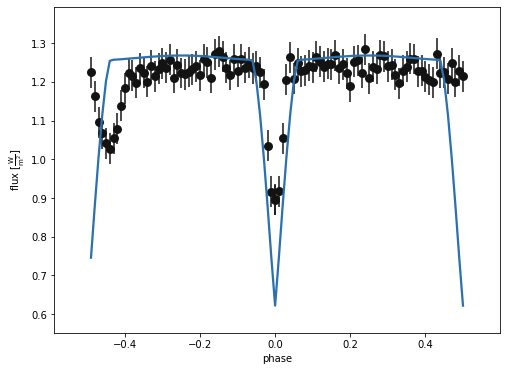

In [5]:
b = phoebe.default_binary()
b.add_dataset('lc', times=times, fluxes=fluxes, sigmas=sigmas_lc)
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_mode_bol', 'manual')
b.set_value_all('atm', 'blackbody')
b.set_value('pblum_mode', 'dataset-scaled')

b.run_compute(model='default')
_ = b.plot(x='phase', show=True)

## EBAI

Let's start with the [EBAI estimator](../api/phoebe.parameters.solver.estimator.ebai.md). As of PHOEBE 2.4, the EBAI estimator supports two methods: 'knn', which uses a trained sklearn.neighbors.kNeighborsRegressor model; and 'mlp' which uses a trained neural network. Both return estimates of the time of superior conjunction, sum of equivalent radii, inclination,  temperature ratio, esinw and ecosw.  

**NOTE**: EBAI with ebai_method='mlp' currently only works if the eclipse widths are less than 0.25 in phase.  If (either) eclipse is detected to be wider than 0.25, NANs will be returned and an error will be raised when attempting to adopt the solution. In this case, or if dealing with a contact binary system, use ebai_method='knn'.

### ebai_method = 'mlp'

Let's first add the solver options via [add_solver](../api/phoebe.frontend.bundle.Bundle.add_solver.md) and set ebai_method to 'mlp'. This should result in the same solution as using the EBAI estimator for PHOEBE <2.4:

In [6]:
b.add_solver('estimator.ebai', ebai_method='mlp', solver='ebai_mlp')
print(b.filter(solver='ebai_mlp'))

Sat, 07 May 2022 13:39 BUNDLE       WARNING adding teffratio constraint to binary orbit (needed for ebai solver)
Sat, 07 May 2022 13:39 BUNDLE       WARNING adding requivsumfrac constraint to binary orbit (needed for ebai solver)


ParameterSet: 7 parameters
         comments@ebai_mlp@solver: 
       use_server@ebai_mlp@solver: none
      lc_datasets@ebai_mlp@solver: ['*']
        phase_bin@ebai_mlp@solver: True
      phase_nbins@ebai_mlp@solver: 500
      ebai_method@ebai_mlp@solver: mlp
            orbit@ebai_mlp@solver: binary


As we can see, by default it selects all available LC datasets and bins the light curves to 500 bins. We can change any of these in the 'ebai01' object or in the call to [run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md). If there are less points that bins, the phase binning is skipped. Just in case, let's turn off the phase binning for this example, since we already have only 100 data points.

In [7]:
b['phase_bin@ebai_mlp'] = False
print(b.filter(solver='ebai_mlp'))

ParameterSet: 6 parameters
         comments@ebai_mlp@solver: 
       use_server@ebai_mlp@solver: none
      lc_datasets@ebai_mlp@solver: ['*']
        phase_bin@ebai_mlp@solver: False
      ebai_method@ebai_mlp@solver: mlp
            orbit@ebai_mlp@solver: binary


In [8]:
b.run_solver('ebai_mlp', solution='ebai_mlp_solution')

<ParameterSet: 13 parameters | qualifiers: adopt_distributions, input_fluxes, ebai_phases, adopt_values, fitted_values, adopt_parameters, input_phases, fitted_units, orbit, ebai_fluxes, input_sigmas, fitted_twigs, comments>

Some of the parameters that the EBAI estimator returns are constrained, so to properly set their values through [adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md), we need to flip the relevant constraints first. Note that simply running `b.adopt_solution()` without this step will result in an error.

In [9]:
try:
    b.adopt_solution('ebai_mlp_solution')
except Exception as e:
    print(e)

Sat, 07 May 2022 13:39 BUNDLE       WARNING teffratio@binary@orbit@component is currently constrained but cannot automatically temporarily flip as solve_for has several options (teff@secondary@star@component, teff@primary@star@component).  Flip the constraint manually first, set adopt_values=False, or remove teffratio@binary@orbit@component from adopt_parameters.  If not addressed, this warning will continue to be raised and will throw an error at adopt_solution.
Sat, 07 May 2022 13:39 BUNDLE       WARNING requivsumfrac@binary@orbit@component is currently constrained but cannot automatically temporarily flip as solve_for has several options (requiv@primary@star@component, requiv@secondary@star@component, sma@binary@orbit@component).  Flip the constraint manually first, set adopt_values=False, or remove requivsumfrac@binary@orbit@component from adopt_parameters.  If not addressed, this warning will continue to be raised and will throw an error at adopt_solution.
Sat, 07 May 2022 13:39 B

failed to pass checks
Run Checks Report: FAIL
ERROR: teffratio@binary@orbit@component is currently constrained but cannot automatically temporarily flip as solve_for has several options (teff@secondary@star@component, teff@primary@star@component).  Flip the constraint manually first, set adopt_values=False, or remove teffratio@binary@orbit@component from adopt_parameters. (3 affected parameters, affecting adopt_solution)
ERROR: requivsumfrac@binary@orbit@component is currently constrained but cannot automatically temporarily flip as solve_for has several options (requiv@primary@star@component, requiv@secondary@star@component, sma@binary@orbit@component).  Flip the constraint manually first, set adopt_values=False, or remove requivsumfrac@binary@orbit@component from adopt_parameters. (3 affected parameters, affecting adopt_solution)
ERROR: esinw@binary@orbit@component is currently constrained but cannot automatically temporarily flip as solve_for has several options (ecc@binary@orbit@co

In [10]:
b.flip_constraint('requivsumfrac', solve_for='requiv@secondary')

b.flip_constraint('teffratio', solve_for='teff@secondary')
b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

Sat, 07 May 2022 13:39 BUNDLE       ERROR   Constraint 'ecc@binary@orbit@constraint' raised the following error while attempting to solve for 'ecc@binary@orbit@component'.  Consider flipping the constraint or changing the value of one of ['per0@binary@orbit@component', 'esinw@binary@orbit@component', 'ecosw@binary@orbit@component', 'ecc@binary@orbit@component'] until the constraint succeeds.  Original error: esinw=0.0 and per0=0.0 results in nan for ecc


<ConstraintParameter: {per0@binary@component} = arctan2({esinw@binary@component}, {ecosw@binary@component}) (solar units) => 0.0 deg>

Finally, we can adopt the EBAI solution and see how it has improved the model light curve:

In [11]:
print(b.adopt_solution('ebai_mlp_solution'))

ParameterSet: 22 parameters
      t0_supconj@binary@component: 0.0 d
       teffratio@binary@component: 0.9451926084008484
   requivsumfrac@binary@component: 0.270969101499463
           esinw@binary@component: 0.09612873033044844
           ecosw@binary@component: 0.1657818310844128
            incl@binary@component: 85.11032114324037 deg
C        teff@secondary@component: 5671.1556504050905 K
C      requiv@secondary@component: 0.43613623794715384 solRad
C            ecc@binary@component: 0.19163597864869963
C           per0@binary@component: 30.107336814608807 deg
C          asini@binary@component: 5.280711534321878 solRad
C         asini@primary@component: 2.640355767160939 solRad
C          incl@primary@component: 85.11032114324037 deg
C    requiv_max@primary@component: 1.6757387267048722 solRad
C       asini@secondary@component: 2.640355767160939 solRad
C        incl@secondary@component: 85.11032114324037 deg
C  requiv_max@secondary@component: 1.6757387267048722 solRad
C        lo

100%|████████████████████████████████████████████████████████████| 101/101 [07:49<00:00,  4.65s/it]


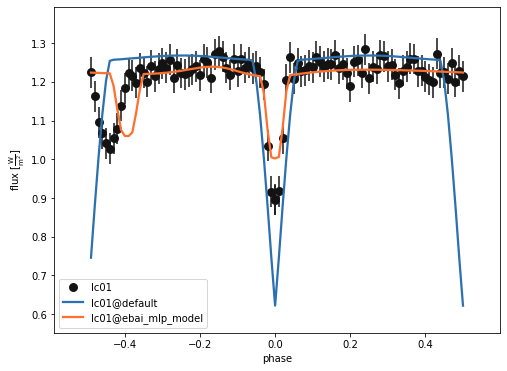

In [12]:
b.run_compute(model='ebai_mlp_model')
_ = b.plot(x='phase', ls='-', legend=True, show=True)

### ebai_method = 'knn'

Let's now compare to the solution obtained with the alternative method:

In [13]:
b.add_solver('estimator.ebai', ebai_method='knn', solver='ebai_knn')

<ParameterSet: 8 parameters | qualifiers: lc_combine, phase_bin, ebai_method, lc_datasets, phase_nbins, orbit, use_server, comments>

In [14]:
b['phase_bin@ebai_knn'] = False
print(b.filter(solver='ebai_knn'))

ParameterSet: 6 parameters
         comments@ebai_knn@solver: 
       use_server@ebai_knn@solver: none
      lc_datasets@ebai_knn@solver: ['*']
        phase_bin@ebai_knn@solver: False
      ebai_method@ebai_knn@solver: knn
            orbit@ebai_knn@solver: binary


In [15]:
b.run_solver('ebai_knn', solution='ebai_knn_solution')

Sat, 07 May 2022 13:48 PHOEBE       WARNING checks will not be run until 'run_checks' or 'run_compute' is called.
Sat, 07 May 2022 13:48 PHOEBE       WARNING constraints will not be run until 'run_delayed_constraints' or 'run_compute' is called.  This may result in inconsistent parameters if printing values before calling either of these methods.


<ParameterSet: 13 parameters | qualifiers: adopt_distributions, input_fluxes, ebai_phases, adopt_values, fitted_values, adopt_parameters, input_phases, fitted_units, orbit, ebai_fluxes, input_sigmas, fitted_twigs, comments>

We have already flipped all the necessary constraints, so we can simply adopt the new solution and compute the resulting model light curve:

In [16]:
print(b.adopt_solution('ebai_knn_solution'))

ParameterSet: 22 parameters
      t0_supconj@binary@component: 0.0 d
       teffratio@binary@component: 0.8777453198478771
   requivsumfrac@binary@component: 0.38604994747833327
           esinw@binary@component: 0.2232629118763779
           ecosw@binary@component: 0.08724125766221195
            incl@binary@component: 79.35225603162343 deg
C        teff@secondary@component: 5266.471919087263 K
C      requiv@secondary@component: 1.0460647216351662 solRad
C            ecc@binary@component: 0.2397026592635212
C           per0@binary@component: 68.65664332648004 deg
C          asini@binary@component: 5.208743132892139 solRad
C         asini@primary@component: 2.6043715664460696 solRad
C          incl@primary@component: 79.35225603162343 deg
C    requiv_max@primary@component: 1.5850999138153807 solRad
C       asini@secondary@component: 2.6043715664460696 solRad
C        incl@secondary@component: 79.35225603162343 deg
C  requiv_max@secondary@component: 1.5850999138153807 solRad
C        lo

100%|████████████████████████████████████████████████████████████| 101/101 [08:05<00:00,  4.81s/it]


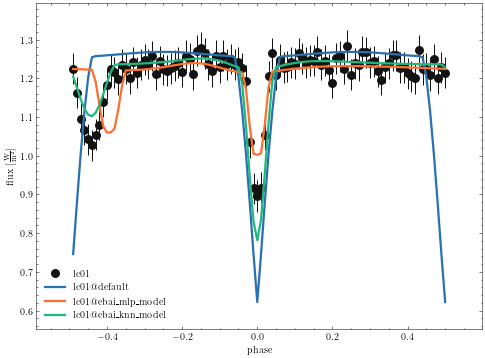

In [17]:
b.run_compute(model='ebai_knn_model')
_ = b.plot(x='phase', ls='-', legend=True, show=True)

## lc_geometry

The EBAI estimators are known to have deficiencies in correctly estimating the eccentricity and argument of periastron (mostly with ebai_method='mlp') and temperature ratio (mostly with ebai_method='knn'), which can be seen in our solution too. As of PHOEBE 2.4, the [lc_geometry estimator](../api/phoebe.parameters.solver.estimator.lc_geometry.md), can also estimate most of the parameters that EBAI can, and can yield better results if the data are uniformly sampled.

Also, as of PHOEBE 2.4, the user has two choices of analytical model to use with lc_geometry: 'two-gaussian' and 'polyfit'. Here we'll use the default, two-Gaussian model. For more on these models, see the [ligeor README](https://github.com/gecheline/ligeor#readme).

In [21]:
b.add_solver('estimator.lc_geometry', solver='lcgeom')

In [22]:
print(b.filter(solver='lcgeom'))

ParameterSet: 10 parameters
           comments@lcgeom@solver: 
         use_server@lcgeom@solver: none
        lc_datasets@lcgeom@solver: ['*']
          phase_bin@lcgeom@solver: True
        phase_nbins@lcgeom@solver: 500
              orbit@lcgeom@solver: binary
   analytical_model@lcgeom@solver: two-gaussian
        interactive@lcgeom@solver: False
      t0_near_times@lcgeom@solver: True
       expose_model@lcgeom@solver: True


The lc_geometry estimator takes similar inputs as EBAI, with two additions: `t0_near_times`, which will return the value of t0_supconj such that it falls within or near the provided times array (otherwise it will be a value in the range [0, period]) and `expose_model`, which if true returns the analytical model fit that's used to determine the eclipse parameters.

In [23]:
b.run_solver('lcgeom', solution='lcgeom_solution')

<ParameterSet: 21 parameters | qualifiers: eclipse_edges, primary_phase, adopt_values, adopt_parameters, input_sigmas, fitted_twigs, secondary_depth, analytic_best_model, analytic_phases, fitted_values, analytic_fluxes, fitted_units, orbit, secondary_width, primary_width, input_fluxes, secondary_phase, input_phases, primary_depth, adopt_distributions, comments>

The resulting solution returns our values of interest (t0, ecc, per0, requivsumfrac, teffratio), as well as the analytical fluxes of all two-Gaussian models (since `expose_model = True`) and the eclipse parameters determined from the best fit:

In [24]:
print(b.filter(solution='lcgeom_solution'))

ParameterSet: 21 parameters
R  orbit@lcgeom@lcgeom_solutio...: binary
R  input_phases@lcgeom@lcgeom_...: [-0.49 -0.48 -0.47 ...  0.48
  0.49  0.5 ]
R  input_fluxes@lcgeom@lcgeom_...: [0.99737632 0.94655178
 0.89186267 ... 0.97735954
 1.         0.98876113]
R  input_sigmas@lcgeom@lcgeom_...: [0.03256553 0.03256553
 0.03256553 ... 0.03256553
 0.03256553 0.03256553]
R  analytic_phases@lcgeom_solu...: [-0.49 -0.48 -0.47 ...  0.48
  0.49  0.5 ]
R  analytic_fluxes@lcgeom_solu...: {'C': array([0.98375167, 0.98375167, 0.98375167, 0.98375167, 0.98375167,
       0.98375167, 0.98375167, 0.98375167, 0.98375167, 0.98375167,
       0.98375167, 0.98375167, 0.98375167, 0.98375167, 0.98375167,
       0.98375167, 0.98375167, 0.98375167, 0.98375167, 0.98375167,
       0.98375167, 0.98375167, 0.98375167, 0.98375167, 0.98375167,
       0.98375167, 0.98375167, 0.98375167, 0.98375167, 0.98375167,
       0.98375167, 0.98375167, 0.98375167, 0.98375167, 0.98375167,
       0.98375167, 0.98375167, 0.98375167, 0.9

To update the values in the bundle, we need to reverse-flip the constraints for esinw and ecosw and adopt the solution.

In [25]:
b.flip_constraint('per0', solve_for='ecosw')
b.flip_constraint('ecc', solve_for='esinw')

<ConstraintParameter: {esinw@binary@component} = {ecc@binary@component} * (sin({per0@binary@component})) (solar units) => 0.2232629118763779>

In [26]:
print(b.adopt_solution('lcgeom_solution'))

ParameterSet: 16 parameters
      t0_supconj@binary@component: 0.9994112974180599 d
             ecc@binary@component: 0.26274941958798653
            per0@binary@component: 70.27258461453721 deg
   requivsumfrac@binary@component: 0.39172027687102673
       teffratio@binary@component: 0.8664969036569549
C     t0_perpass@binary@component: 0.968286508780005 d
C         t0_ref@binary@component: 1.023084884850735 d
C     compute_phases@lc01@dataset: []
C    requiv_max@primary@component: 1.54091174182295 solRad
C  requiv_max@secondary@component: 1.54091174182295 solRad
C          ecosw@binary@component: 0.0886899375143809
C          esinw@binary@component: 0.24732843038663999
C      requiv@secondary@component: 1.0761174674164415 solRad
C        teff@secondary@component: 5198.981421941729 K
C      mean_anom@binary@component: 11.416873881131664 deg
C        logg@secondary@component: 4.3738325158271465


100%|████████████████████████████████████████████████████████████| 101/101 [08:22<00:00,  4.97s/it]


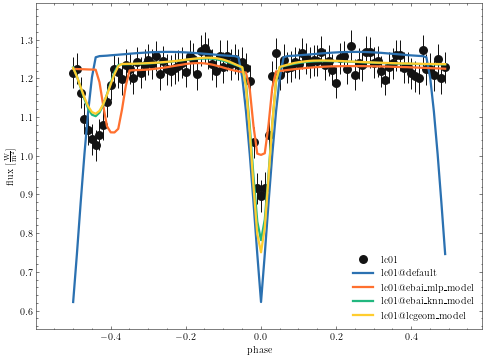

In [27]:
b.run_compute(model='lcgeom_model')
_ = b.plot(x='phases', ls='-', legend=True, show=True)

We see that in this case the results from EBAI with 'knn' and lc_geometry are pretty similar so it goes to show that the estimators can be used interchangeably or combined to yield the best possible estimate!

## phase masking

For more details on phase-masking see [Advanced: Phase Masking](mask_phases.ipynb).

lc_geometry also returns suggested `mask_phases` computed from the eclipse widths, which we can notice in the list of `fitted_twigs`. However, by default it is excluded from the `adopt_parameters` list:

In [28]:
print(b.get_value('fitted_twigs', solution='lcgeom_solution'))
print(b.get_value('adopt_parameters', solution='lcgeom_solution'))

['t0_supconj@binary@orbit@component' 'ecc@binary@orbit@component'
 'per0@binary@orbit@component' 'requivsumfrac@binary@orbit@component'
 'teffratio@binary@orbit@component' 'mask_phases@binary@lc01@lc@dataset']
['t0_supconj@binary@orbit@component', 'ecc@binary@orbit@component', 'per0@binary@orbit@component', 'requivsumfrac@binary@orbit@component', 'teffratio@binary@orbit@component']


Therefore, we can set them in the bundle by either adding `mask_phases` the to the `adopt_parameters` list before calling `adopt_solution()`, or after, as:

In [29]:
b.set_value('mask_phases', b.get_value('fitted_values', solution='lcgeom_solution')[-1])

If we now plot the light curves, we'll see only the eclipses have been "masked out" of the data.

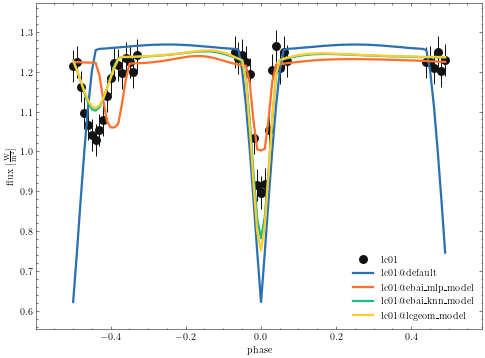

In [30]:
_ = b.plot(x='phases', ls='-', legend=True, show=True)